In [11]:
from nilearn import datasets
from nilearn.decomposition import DictLearning
from nilearn import image
from nilearn import plotting
from nilearn.regions import RegionExtractor
from nilearn.connectome import ConnectivityMeasure       
import numpy as np                                                                     

In [2]:
# Fetch brain development functional datasets
dataset = datasets.fetch_development_fmri(n_subjects=20)
func_filenames = dataset.func
confounds = dataset.confounds

In [3]:
# Extract functional networks with DictionaryLearning
dict_learn = DictLearning(n_components=8, smoothing_fwhm=6.,
                          random_state=0)

D:\anaconda\envs\mne\lib\site-packages\nilearn\image\image.py:1054: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(
D:\anaconda\envs\mne\lib\site-packages\nilearn\plotting\displays.py:101: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),
D:\anaconda\envs\mne\lib\site-packages\nilearn\plotting\displays.py:101: UserWarning: linewidths is ignored by contourf
  im = getattr(ax, type)(data_2d.copy(),


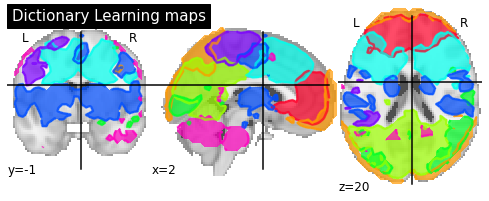

In [4]:
# Import dictionary learning algorithm from decomposition module and call the object and fit the model to the functional datasets
# Fit to the data
dict_learn.fit(func_filenames)
# Resting state networks/maps in attribute `components_img_`
components_img = dict_learn.components_img_
plotting.plot_prob_atlas(components_img, view_type='filled_contours', title='Dictionary Learning maps')

# Extract regions from networks

D:\anaconda\envs\mne\lib\site-packages\numpy\ma\core.py:2829: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


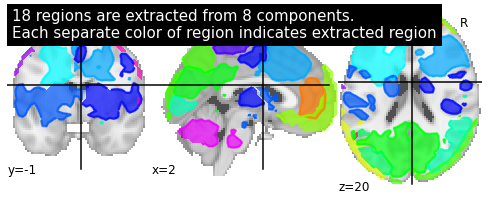

In [7]:
extractor = RegionExtractor(components_img, threshold=0.5,
                            thresholding_strategy='ratio_n_voxels',
                            extractor='local_regions',
                            standardize=True, min_region_size=1350)
# Just call fit() to process for regions extraction
extractor.fit()
# Extracted regions are stored in regions_img_
regions_extracted_img = extractor.regions_img_
# Each region index is stored in index_
regions_index = extractor.index_
# Total number of regions extracted
n_regions_extracted = regions_extracted_img.shape[-1]

# Visualization of region extraction results
title = ('%d regions are extracted from %d components.'
         '\nEach separate color of region indicates extracted region'
         % (n_regions_extracted, 8))
plotting.plot_prob_atlas(regions_extracted_img, view_type='filled_contours',
                         title=title)

# Compute correlation coefficients

In [8]:
correlations = []
# Initializing ConnectivityMeasure object with kind='correlation'
connectome_measure = ConnectivityMeasure(kind='correlation')
for filename, confound in zip(func_filenames, confounds):
    # call transform from RegionExtractor object to extract timeseries signals
    timeseries_each_subject = extractor.transform(filename, confounds=confound)
    # call fit_transform from ConnectivityMeasure object
    correlation = connectome_measure.fit_transform([timeseries_each_subject])
    # saving each subject correlation to correlations
    correlations.append(correlation)

In [9]:
mean_correlations = np.mean(correlations, axis=0).reshape(n_regions_extracted, n_regions_extracted)

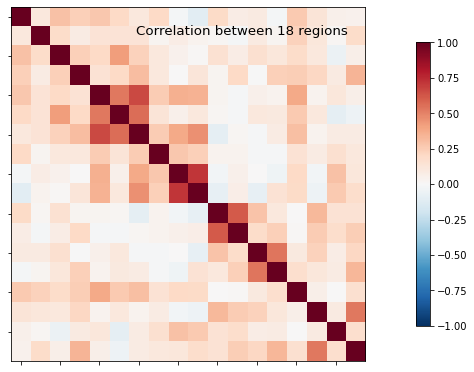

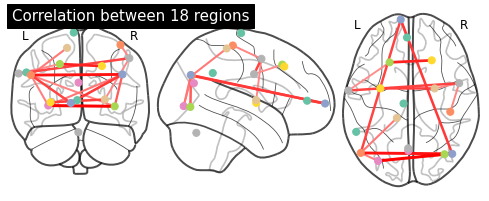

In [10]:
# Plot resulting connectomes
title = 'Correlation between %d regions' % n_regions_extracted

# First plot the matrix
display = plotting.plot_matrix(mean_correlations, vmax=1, vmin=-1,
                               colorbar=True, title=title)

# Then find the center of the regions and plot a connectome
regions_img = regions_extracted_img
coords_connectome = plotting.find_probabilistic_atlas_cut_coords(regions_img)

plotting.plot_connectome(mean_correlations, coords_connectome,
                         edge_threshold='90%', title=title)

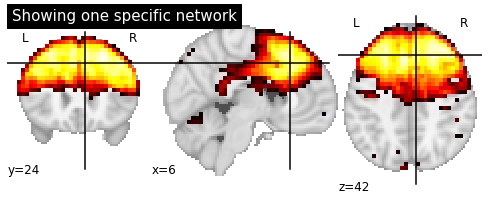

In [14]:
img = image.index_img(components_img, 4)
coords = plotting.find_xyz_cut_coords(img)
display = plotting.plot_stat_map(img, cut_coords=coords, colorbar=False, title='Showing one specific network')

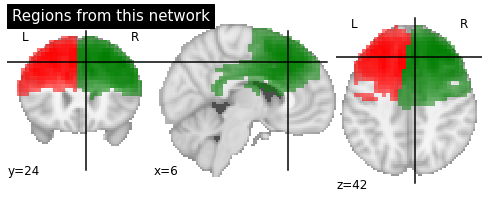

In [16]:
# For this, we take the indices of the all regions extracted related to original network given as 4.
regions_indices_of_map3 = np.where(np.array(regions_index) == 4)

display = plotting.plot_anat(cut_coords=coords,
                             title='Regions from this network')

# Add as an overlay all the regions of index 4
colors = 'rgbcmyk'
for each_index_of_map3, color in zip(regions_indices_of_map3[0], colors):
    display.add_overlay(image.index_img(regions_extracted_img, each_index_of_map3),
                        cmap=plotting.cm.alpha_cmap(color))

plotting.show()